<a href="https://colab.research.google.com/github/tylee33/Paper_Research/blob/main/Gold_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%html
<marquee style='width: 70%; color: green;'><b> Tae Young Lee  </b>  </marquee>

In [2]:
# install required packages
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install('yahoofinancials')
install ('pmdarima')
install ('pycaret')


In [3]:
import pandas as pd

print(pd.__version__)
# 출력 결과 : 2.1.4

1.5.3


In [4]:
!pip install pandas==1.5.3

# Import Libraries


In [5]:
#Importing Libraries
from IPython import get_ipython
get_ipython().magic('reset -sf')

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Patch

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from statistics import mean
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
from pycaret.regression import *


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import  mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

import gc
from datetime import datetime
import numpy as np
from math import sqrt
from yahoofinancials import YahooFinancials
import datetime




# General Settings

In [6]:
start_date = "2010-01-02"
end_date= "2020-07-21"

# Dataframe to keep our results
summary = pd.DataFrame(columns = ['Model', 'MAE' ,'Prediction','validation'])

In [7]:
# Helper Functions

# helper function to show null records summary
def show_null_records(df, show=True):
    print("\nNumber of Records with null values\n")
    total = df.shape[0] - df.dropna().shape[0]
    print(total)

    if show and total > 0:
        print("\nRecords with null values\n")
        display(df[df.isna().any(axis=1)])

    return df.isna().any(axis=1)


# Define a function to visualize cross-validation behavior¶
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Train and Test Records', ylabel="CV iteration",
           ylim=[n_splits, -.2], xlim=[0, 2400])

    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def cal_MAPE(a, b):
    c = [abs(i - j) / i * 100 if i != 0 else None for i, j in zip(a, b)]

    return c.mean()


# print datafarme information for quick test
def p(df, rows=3):
    display(df.info())
    display(df.head(rows))
    display(df.tail(rows))

#df = pd.DataFrame(df).append(new_row, ignore_index=True)
#df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

def add_result(to_append):
  global summary
  a_series = pd.Series(to_append, index=summary.columns)
  summary=summary.append(a_series, ignore_index=True)
  return summary

# Import Financial Data


In [8]:
def make_initial_data():
  yahoo_financials = YahooFinancials('GC=F')
  values=yahoo_financials.get_historical_price_data(start_date, end_date, "daily")

  #Extracting the closing prices from the JSON file
  values = pd.DataFrame(values['GC=F']['prices'])[['formatted_date','adjclose']]
  values.columns=['date', 'Gold']

  values['date']= pd.to_datetime(values['date'])
  values['year'] = [d.year for d in values.date]
  values['month'] = [d.strftime('%b') for d in values.date]
  values["month"] = pd.to_datetime(values.month, format='%b', errors='coerce').dt.month

  years = values['year'].unique()


  # reordering the columns
  values = values[['date', 'year', 'month', 'Gold']]
  values=values.set_index('date')

  # remove the records which gold price is  null
  values=values.dropna()
  return values

values=make_initial_data()

In [9]:
###  Let's see a sample of Json output from Yahoo Financial Package
yahoo_financials = YahooFinancials('GC=F')
display(yahoo_financials.get_historical_price_data("2020-07-12", "2020-07-14", "Daily"))

{'GC=F': {'eventsData': {},
  'firstTradeDate': {'formatted_date': '2000-08-30', 'date': 967608000},
  'currency': 'USD',
  'instrumentType': 'FUTURE',
  'timeZone': {'gmtOffset': -14400},
  'prices': [{'date': 1594612800,
    'high': 1811.0,
    'low': 1805.0,
    'open': 1805.0,
    'close': 1811.0,
    'volume': 164,
    'adjclose': 1811.0,
    'formatted_date': '2020-07-13'}]}}

In [10]:
# let's see how our dataset looks like so far
display(values.tail())

,year,month,Gold
date,,,
2020-07-14,2020,7,1810.599976
2020-07-15,2020,7,1811.400024
2020-07-16,2020,7,1798.699951
2020-07-17,2020,7,1808.300049
2020-07-20,2020,7,1815.900024


# Time Series Analysis

## Summary Statistics

In [11]:
values.describe()

,year,month,Gold
count,2651.000000,2651.000000,2651.000000
mean,2014.783478,6.402112,1363.419163
std,3.053221,3.413257,189.161540
min,2010.000000,1.000000,1050.800049
25%,2012.000000,3.000000,1227.350037
50%,2015.000000,6.000000,1303.099976
75%,2017.000000,9.000000,1499.000000
max,2020.000000,12.000000,1888.699951


In [12]:
values.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2651 entries, 2010-01-04 to 2020-07-20
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    2651 non-null   int64  
 1   month   2651 non-null   int64  
 2   Gold    2651 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 82.8 KB


## How Gold Prices Are Fluctuated Over the Time

In [13]:
desc="use taps and slider to visualize different portion of data"
fig = px.line(values, x=values.index, y='Gold', title='Gold Prices',
                 labels={
                     "x": "Date",
                     "Gold": "Gold Price",
                 })
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="Last Month", step="month", stepmode="backward"),
            dict(count=6, label="Last 6 Months", step="month", stepmode="backward"),
            dict(count=1, label="Since Jan 2020", step="year", stepmode="todate"),
            dict(count=1, label="Last Year", step="year", stepmode="backward"),
            dict(count=5, label="Last 5 Years", step="year", stepmode="backward"),
            dict(step="all", label="Since Jan 2010")
        ])
    )
)
fig.show()

## Gold Price Density Plot

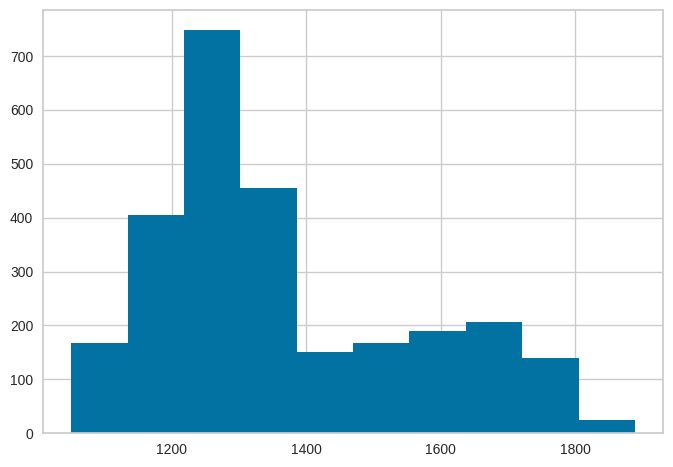

In [14]:
values.Gold.hist()
plt.show()

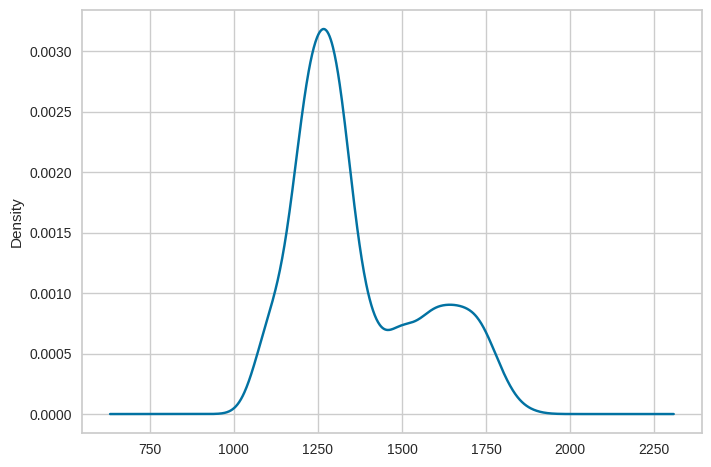

In [15]:
values.Gold.plot(kind='kde')
plt.show()

## Gold Price Patterns



### Trend

 #### Comparing Year-Wise Patterns Side-by-Side
Let's plot each year as a separate line in the same plot.

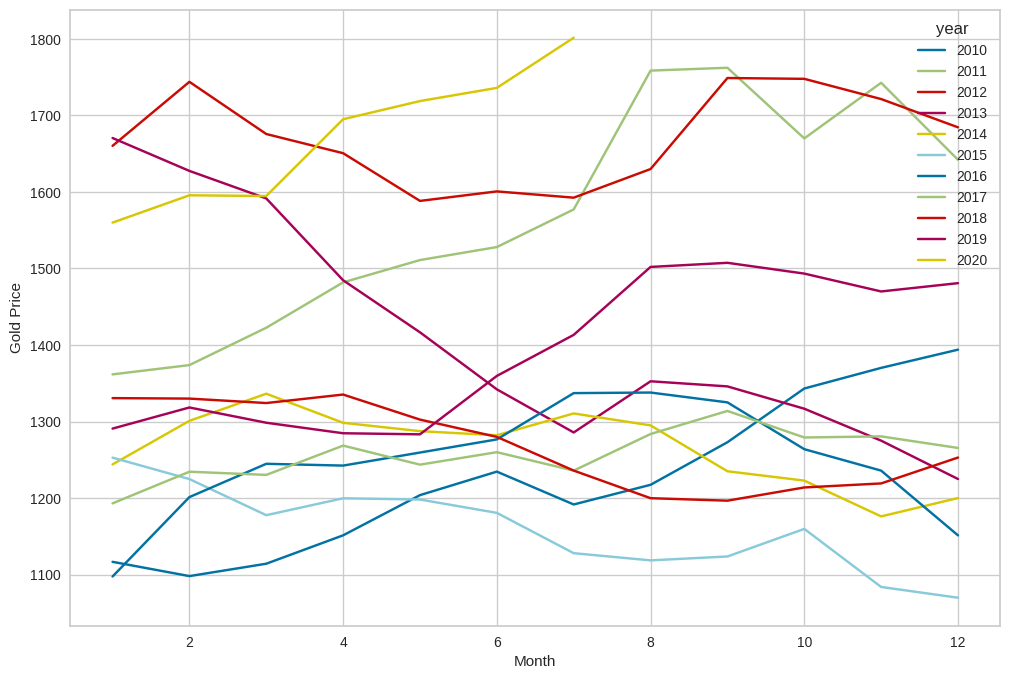

In [16]:
df_pivot = pd.pivot_table(values, values='Gold', index='month', columns='year', aggfunc='mean')
df_pivot = df_pivot.sort_values(by="month")

df_pivot.plot(figsize=(12,8))

plt.xlabel('Month')
plt.ylabel('Gold Price')
plt.show()

#### Trend  using Box Plot
A trend is observed when there is an increasing or decreasing slope observed in the time series.

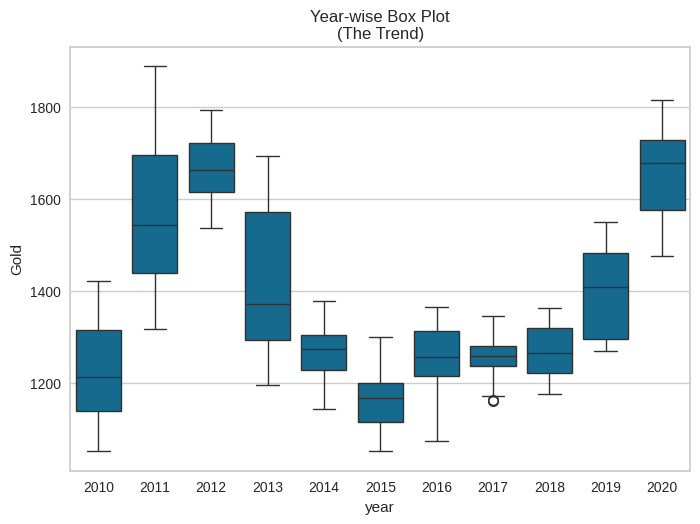

In [17]:
axes=sns.boxplot(x='year', y='Gold', data=values)
axes.set_title('Year-wise Box Plot\n(The Trend)', fontsize=12);
plt.show()

### Seasonality Patterns

seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day.

#### Seasonality Patterns Using Box Plot


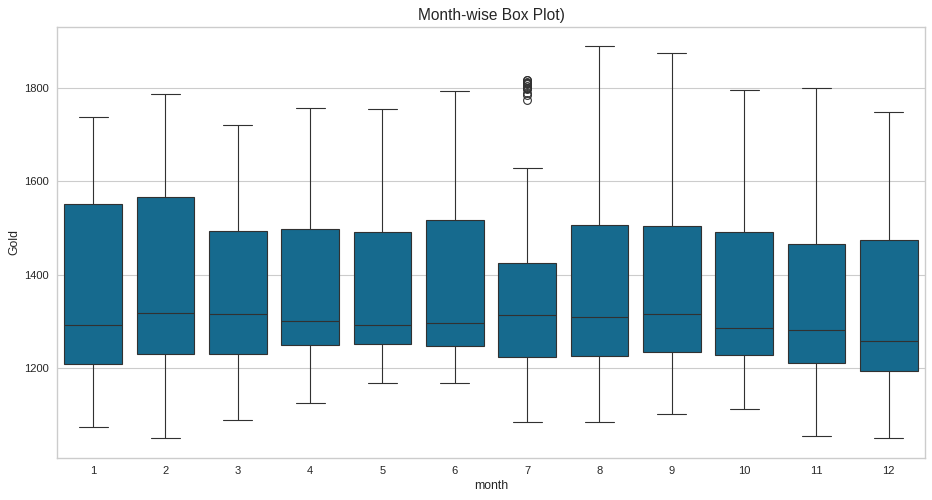

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(14,7), dpi= 80)
axes=sns.boxplot(x='month', y='Gold', data=values)
axes.set_title('Month-wise Box Plot)', fontsize=14)
plt.show()

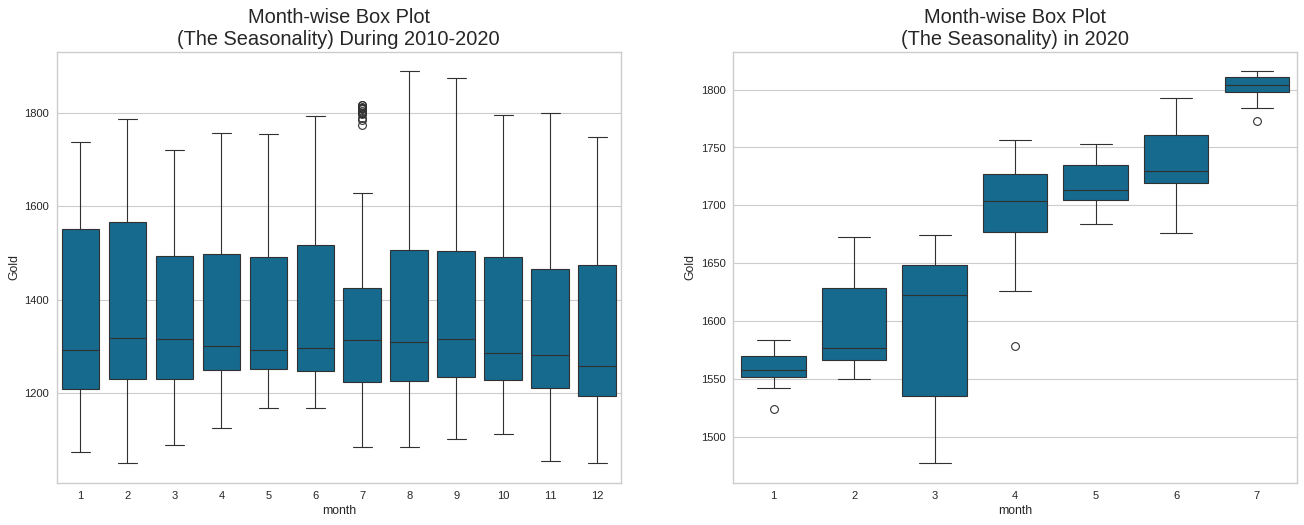

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y='Gold', data=values, ax=axes[0])
sns.boxplot(x='month', y='Gold', data=values.loc[values.year.isin([2020]), :])

axes[0].set_title('Month-wise Box Plot\n(The Seasonality) During 2010-2020', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality) in 2020', fontsize=18)
plt.show()

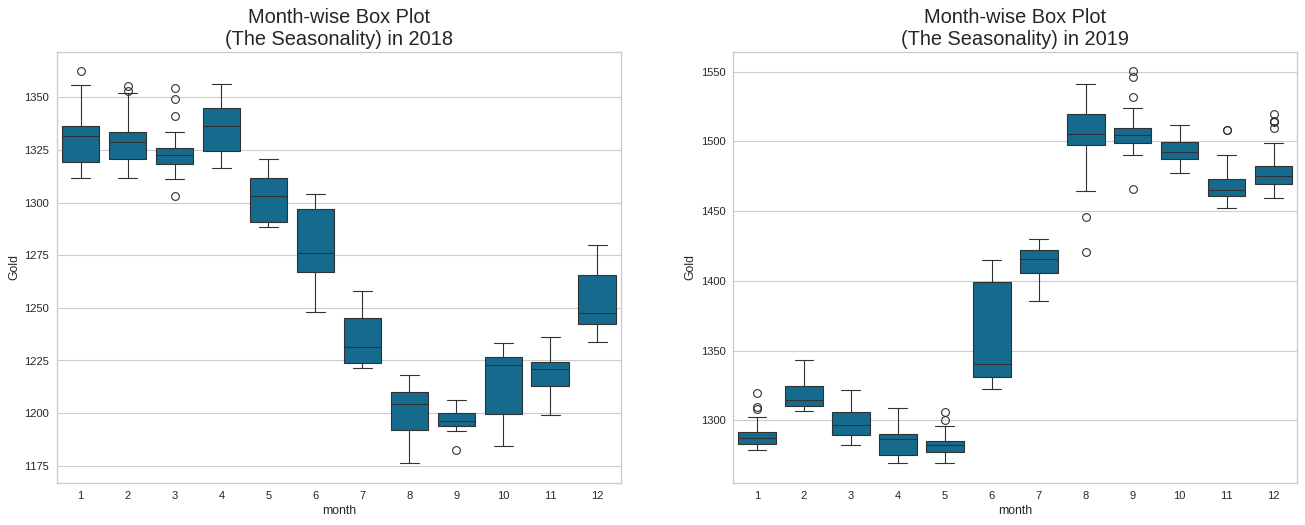

In [20]:

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='month', y='Gold', data=values.loc[values.year.isin([2018]), :], ax=axes[0])
sns.boxplot(x='month', y='Gold', data=values.loc[values.year.isin([2019]), :])

axes[0].set_title('Month-wise Box Plot\n(The Seasonality) in 2018', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality) in 2019', fontsize=18)
plt.show()

As the figures show the patterns is not of fixed calendar based frequencies. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”.

### Lag Scatter Plots
Previous observations in a time series are called lags. A useful type of plot to explore the relationship between each observation and a lag of that observation is scatter plot.

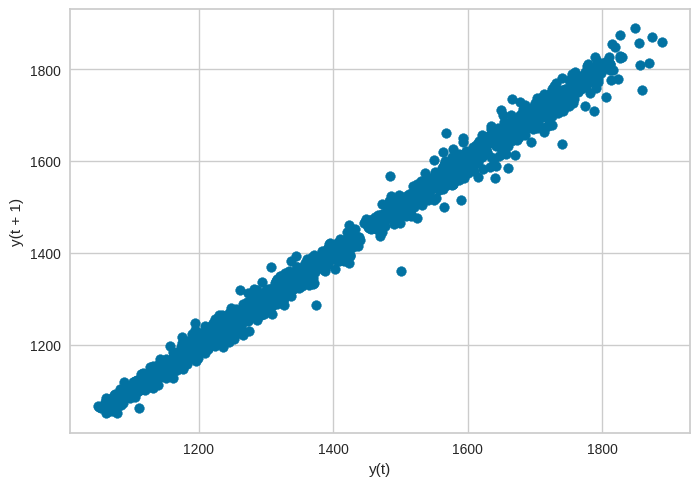

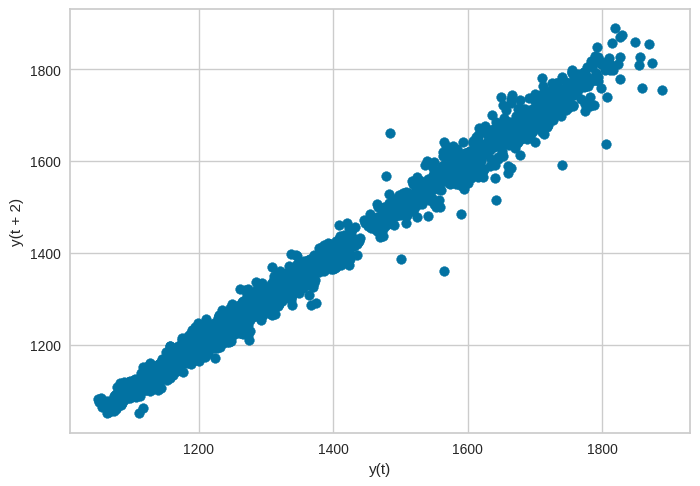

In [21]:
for i in range(1,3):
  lag_plot(values.Gold,lag=i)
  plt.show()

The figures suggests a strong good positive correlation with lagged gold price.




### Autocorrelation Plots


Autocorrelation function and partial autocorrelation function plots provide information about the dependency of time series values to their previous values(self-correlation). If the time series is stationary, the ACF/PACF plots will show a quick cut off after a small number of lags.


In [22]:
def time_series_plot(y, lags=None, figsize=(14, 9), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

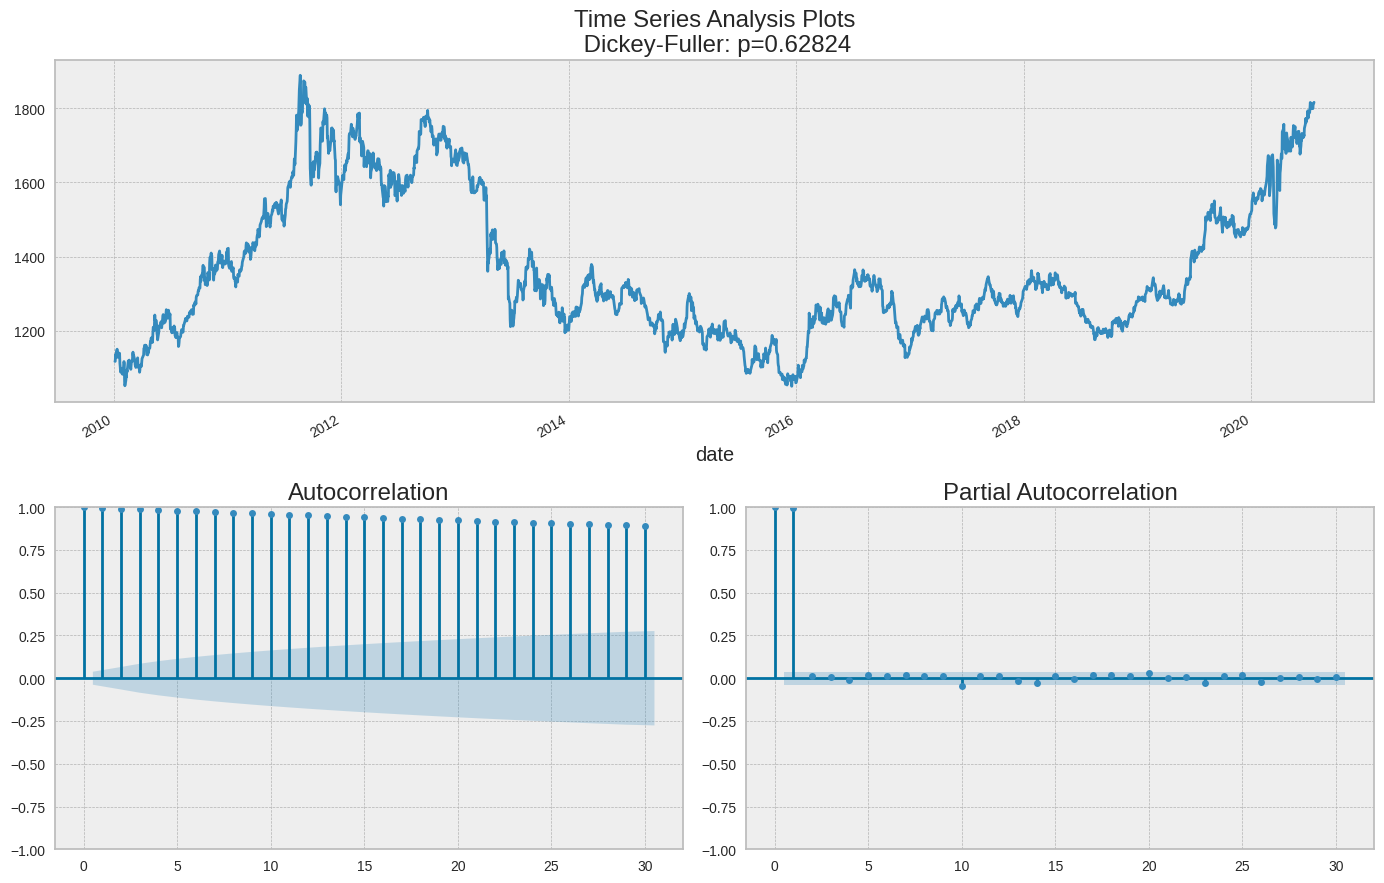

In [23]:
time_series_plot(values.Gold, lags=30)

 ACF shows that our time series is not stationary, as it does not show a quick cut off into the 95% confidence interval area.

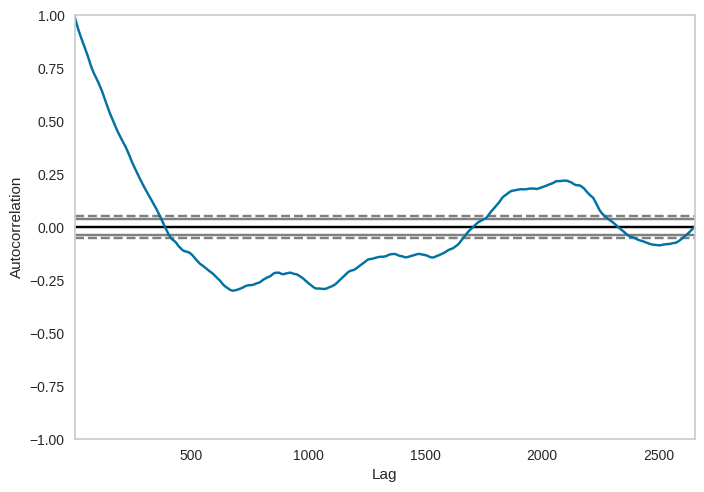

In [24]:
 autocorrelation_plot(values.Gold)
plt.show()

Dotted lines are provided that indicate any correlation values above those lines are statistically significant.

### Dickey-Fuller Test

Based on the figures above, we understood that that our time series is not stationary. Here, we apply Augmented Dickey-Fuller test to confirm  this.

 The null hypothesis of the test says that our time series is non-stationary. If the p-value is lower than 5%, we reject the null hypothesis and time series is stationary.  Otherwise, we fail to reject the null hypothesis and time series is non-stationary

In [25]:
dftest = adfuller(values['Gold'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -1.302042
p-value                           0.628237
#Lags Used                        9.000000
Number of Observations Used    2641.000000
Critical Value (1%)              -3.432828
Critical Value (5%)              -2.862635
Critical Value (10%)             -2.567353
dtype: float64


Since the p-value is higher than 0.05, we fail to reject the null hypothesis and our time series is non-stationary.

The dataset is non-stationary, meaning that the mean and the variance of the observations change over time. This makes it difficult to model by both classical statistical methods and more sophisticated machine learning methods.

## Convert to a Non-Stationary Series

 We can convert our time series to stationary by taking the first difference. That is replacing each observation as the difference between it and the previous value.

An important reason is  that some models works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem by making the predictors(lags of the series) in the forecasting models nearly independent.

In [26]:
# difference data with its previous value
df_diff = values['Gold'].diff(1).dropna()


df_diff.describe()

,Gold
count,2650.000000
mean,0.263472
std,14.673779
min,-140.400024
25%,-6.099976
50%,0.300049
75%,7.500000
max,93.199951


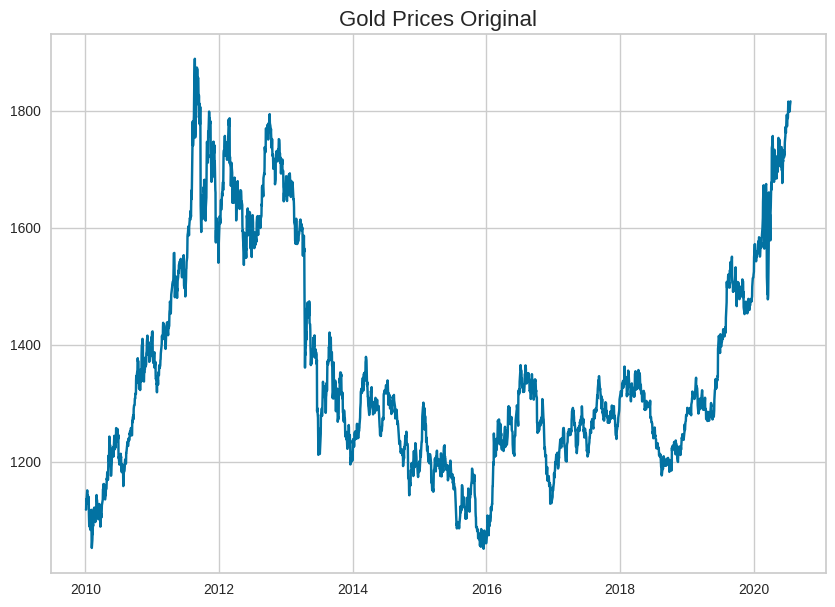

In [27]:
plt.figure(figsize=(10,7))
plt.plot(values['Gold'])
plt.title('Gold Prices Original', fontsize=16)
plt.show()

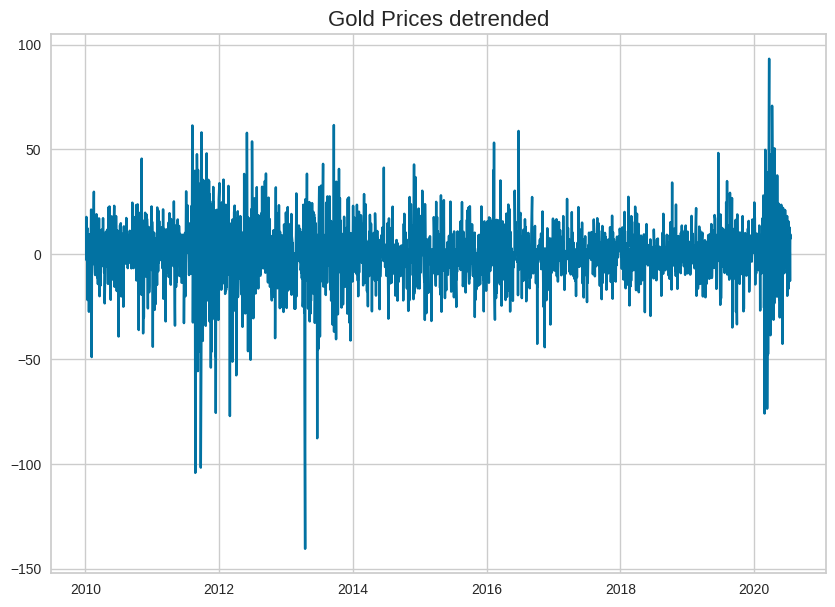

In [28]:
plt.figure(figsize=(10,7))
plt.plot(df_diff)
plt.title('Gold Prices detrended', fontsize=16)
plt.show()

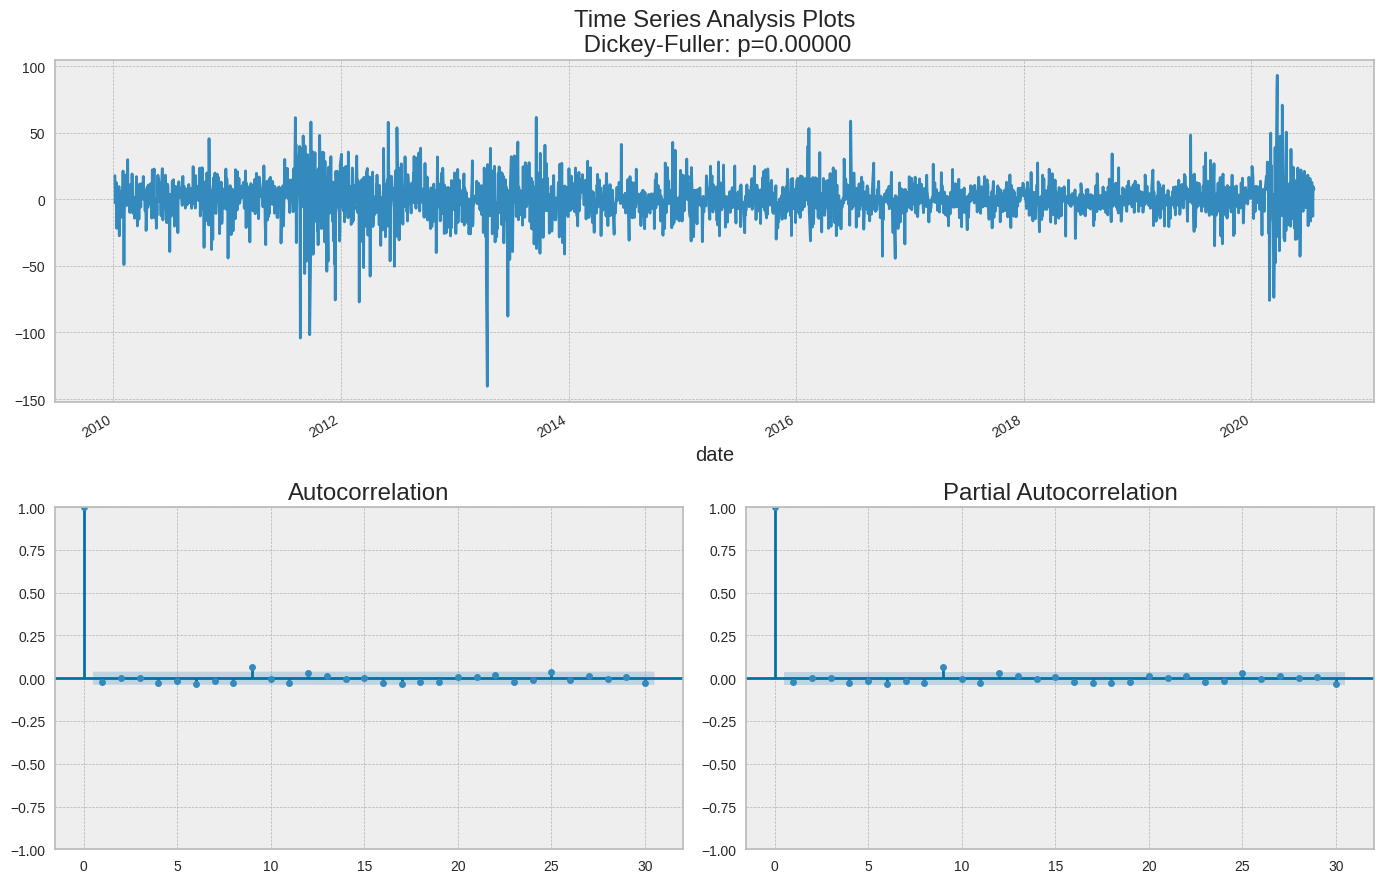

In [29]:
time_series_plot(df_diff[1:], lags=30)

In [30]:
dftest = adfuller(df_diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.737526e+01
p-value                        5.110011e-30
#Lags Used                     8.000000e+00
Number of Observations Used    2.641000e+03
Critical Value (1%)           -3.432828e+00
Critical Value (5%)           -2.862635e+00
Critical Value (10%)          -2.567353e+00
dtype: float64


Applying the previously listed stationarity checks, we notice the plot of differenced time series does not reveal any specific trend or seasonal behavior, ACF/PACF plots have a quick cut-off, and ADF test result returns p-value almost 0.00. which is lower than the threshold. All these checks suggest that differenced data is stationary. This suggests that techniques shuch as Arima must include at least one order of differencing.

## Random Walk Time Series
Our previous analysis suggest that our time series is a random  walk time series.  A random walk cannot easily be predicted, as future steps cannot be predicted on the basis of past history.  








# Time Series Prediction

 Given the way that the random walk is constructed, the best prediction would be to use the observation at the previous time step as what will happen in the next time step.  This is  called  a persistence model.



In this section, we univariate data  of Gold closing price. This is because it is the simplest to understand and work with. Multivariate data is often more difficult to work with. It is harder to model and often many of the classical methods do not perform well.

### Train & Test Split

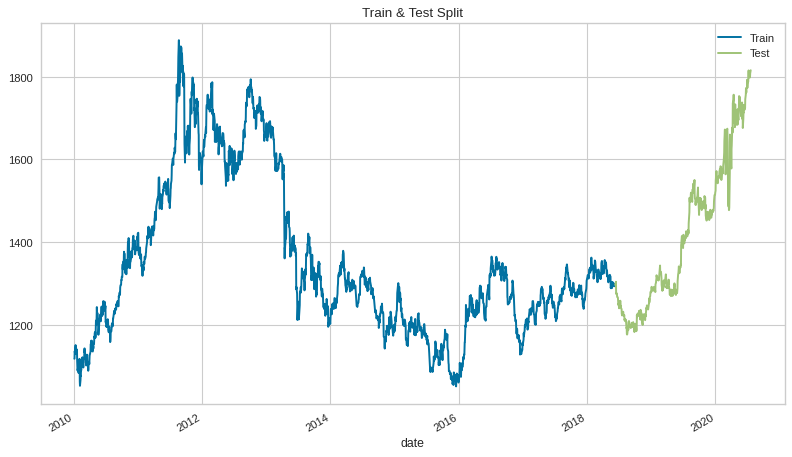

Observations: 2651
Training Observations: 2120
Testing Observations: 531


In [31]:
#divide into train and validation set

figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')

train_size=int(values.shape[0]*0.8)
train = values[:train_size]
test = values[train_size:]

train['Gold'].plot(label='Train')
test['Gold'].plot(label='Test')


plt.legend(loc='best')
plt.title('Train & Test Split')
plt.show(block=False)

print('Observations: %d' % (len(values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

## Walk Forward Validation

Our time series models Should be evaluated using walk-forward validation.

The walk-forward validation will work as follows:

1. The first 80% of the dataset will be held back to train the model.
2. The remaining 20% of the dataset will be iterated and test the model.
3. For each step in the test dataset:

  *   A model will be trained.
  *   A one-step prediction made and the prediction stored for later evaluation.
  *  The actual observation from the test dataset will be added to the training dataset for the next iteration.

4. The predictions made during the iteration of the test dataset will be evaluated and an MAE score reported.



In [32]:
def walk_forward(func, train, test, future_steps=1, trace=False):
  print ("walk-forward validation using", func)
  predictions = list()
  past_data = [x for x in train]
  y_true= test.shift(-future_steps)[:-future_steps]


  for i in range(len(y_true)):
    yhat = func(past_data,future_steps)
    predictions.append(yhat)
    past_data.append(test[i])



  if trace:
    for i in range(len(predictions)):
      print("predicted:", predictions[i], "True Value: ", y_true[i])

  rmse = sqrt(mean_squared_error(y_true , predictions))
  print('RMSE: %.3f' % rmse)

  mae =  mean_absolute_error(y_true , predictions)
  print('MAE: %.3f' % mae)

  return  predictions, rmse, mae

## Recursive Multi-step Forecast Strategy

Predicting multiple time steps into the future is called multi-step time series forecasting. As in this challenge, we require to forcast the next four steps, we use recursive multi-step forecast Strategy.

In this strategy, we use one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.

## Persistence Model (Benchmark Model)

As the purpose of this challenge is predicting the price of gold at market close on Friday July 24th and our submissions will be due on Tuesday July 21st, we use lag equal to 4.

In [33]:
def persistence_model(past_data,future_steps=4 ):
  prediction = past_data [-1]
  return prediction



predictions, rmse, mae = walk_forward(persistence_model, train['Gold'], test['Gold'], future_steps=4, trace=False)

pred=persistence_model(values['Gold'])
print ("The gold closing price on 24th July 2020 will be:", pred)

add_result(['Persistence', mae, pred,'Walk Forward Validation'])

walk-forward validation using <function persistence_model at 0x7e12bd161240>
RMSE: 33.072
MAE: 21.314
The gold closing price on 24th July 2020 will be: 1815.9000244140625


,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation


##  ARIMA Model

In [34]:
import warnings

def model_arima(past_data,future_steps ):
  order=(3,1,2)
  model = ARIMA(past_data, order=order)
  model_fit = model.fit()
  prediction = model_fit.forecast(future_steps)[0]
  return prediction
warnings.filterwarnings("ignore")
predictions, rmse, mae = walk_forward(model_arima, train['Gold'], test['Gold'], future_steps=4, trace=False)


walk-forward validation using <function model_arima at 0x7e12bd161900>
RMSE: 33.104
MAE: 21.362


According to a study done by Yang (2019), Arima with  order of (3,1,2) achieves high performance for predicting Gold price. Hence, we use this value as our limited time does not allow for fine tuning of Arima parameters.

---


Yang, X. (2019, January). The Prediction of Gold Price Using ARIMA Model. In 2nd International Conference on Social Science, Public Health and Education (SSPHE 2018). Atlantis Press.

In order to find the final prediction of Arima for 24th July, we train Arima over whole training set and then predict the next 4 days price.

In [44]:
all=train.Gold.append(test.Gold)
order=(3,1,2)
model = ARIMA(all, order=order)
model_fit = model.fit()

pred=model_fit.forecast(4)
print ("The gold closing price on 24th July 2020 will be:", pred)

add_result(['Arima', mae, pred, 'Walk Forward Validation'])

The gold closing price on 24th July 2020 will be: 2651    1815.761380
2652    1815.800030
2653    1815.809985
2654    1815.809751
Name: predicted_mean, dtype: float64


,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation


In [46]:
summary

,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation


###  Arima Model Diagnostics

Let's review Arima residual forecast errors. Ideally, the distribution of residual errors should be white noise. White noise time series is defined by a zero mean, constant variance, and zero correlation.

                0
count  527.000000
mean     1.012719
std     14.745869
min    -75.833638
25%     -4.686382
50%      0.819458
75%      6.975293
max     98.719765


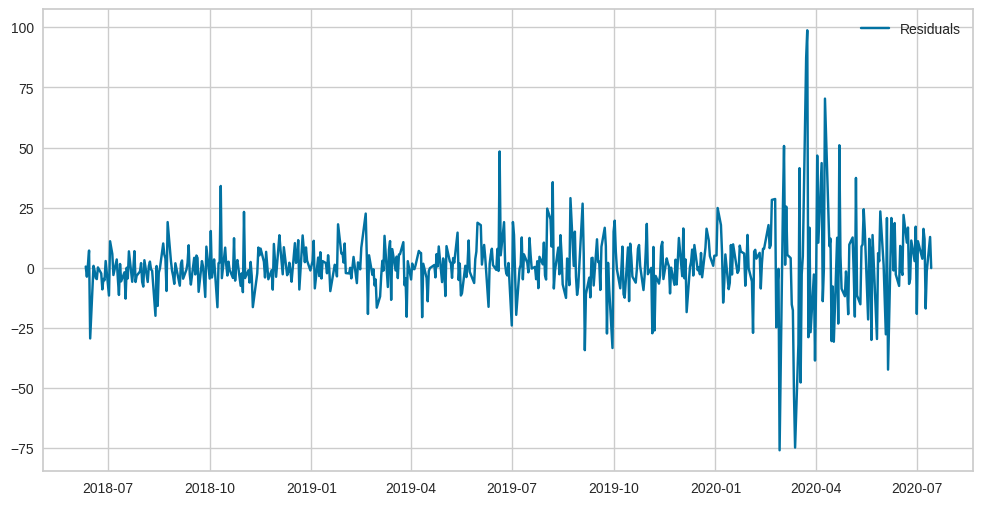

In [47]:
residuals = [test['Gold'][i] - predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.describe())

plt.figure(figsize=(12,6))
plt.plot(test[:len(residuals)].index, residuals, label='Residuals')
plt.legend()
plt.show()

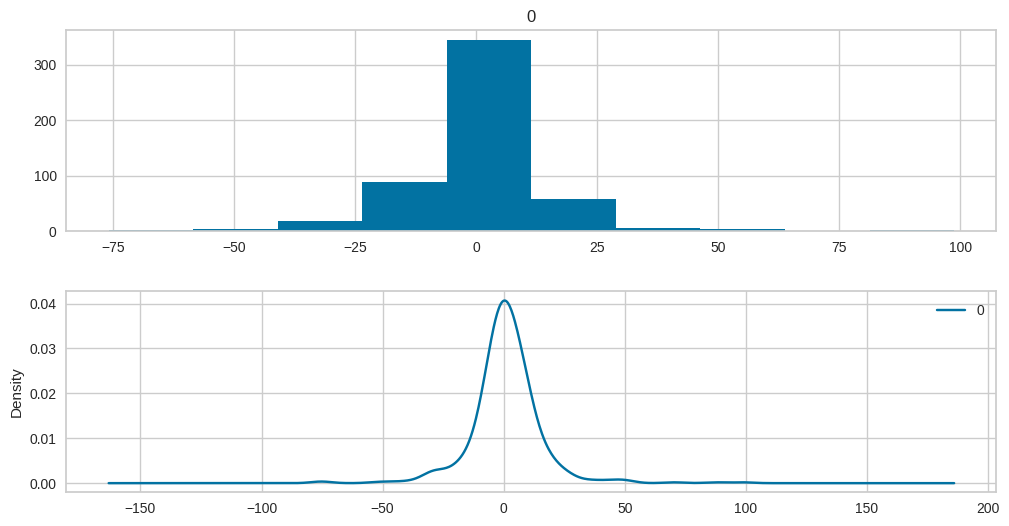

In [49]:
plt.figure(figsize=(12,6))
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

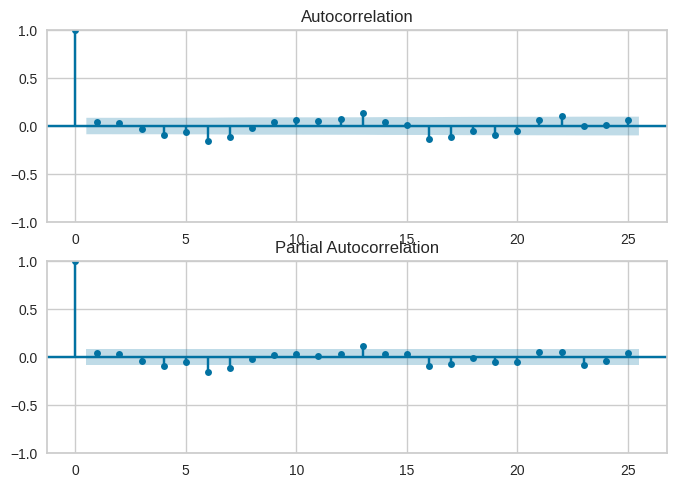

In [50]:
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

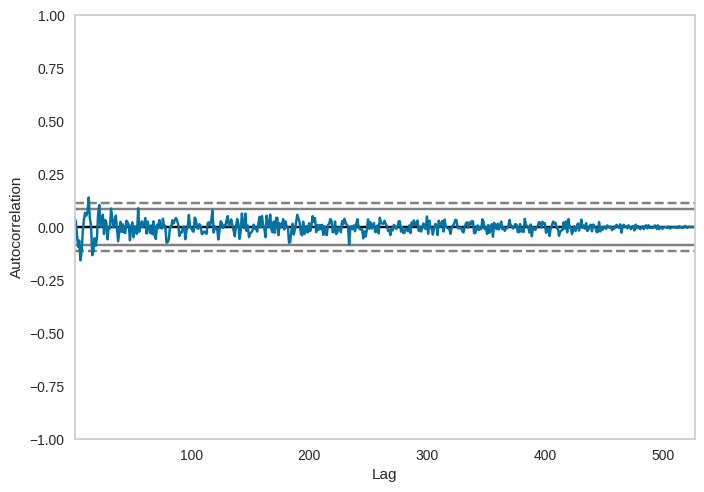

In [51]:
autocorrelation_plot(residuals)
plt.show()

All the above figures, suggests that Arima(3,1,2) is performing almost fine.  Let's compare its prediction with the real outcome

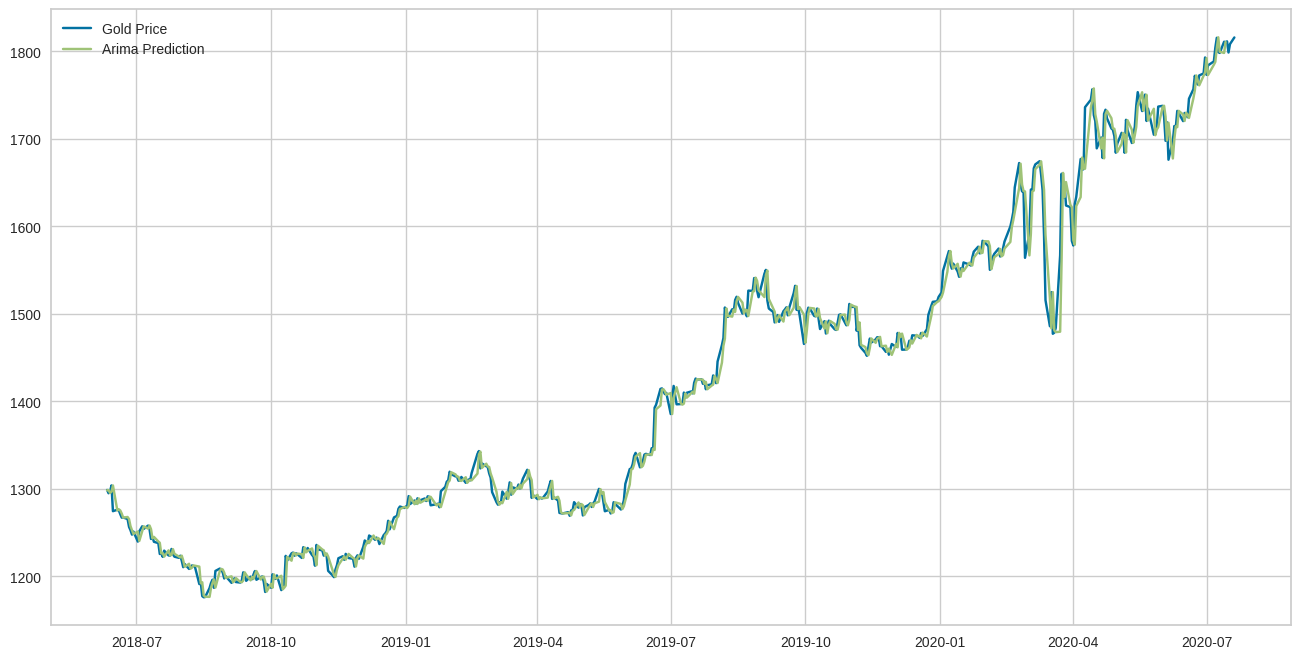

In [52]:
plt.figure(figsize=(16,8))
plt.plot(test.index, test['Gold'], label='Gold Price')
plt.plot(test[:len(predictions)].index, predictions, label='Arima Prediction')
plt.legend()
plt.show()

## Moving Average

Let's see how moving averge performs in predicting Gold price

In [53]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.95):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(14,7))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    print ("MAE for window size: ",window," is ", mae)


MAE for window size:  5  is  11.116272747705853


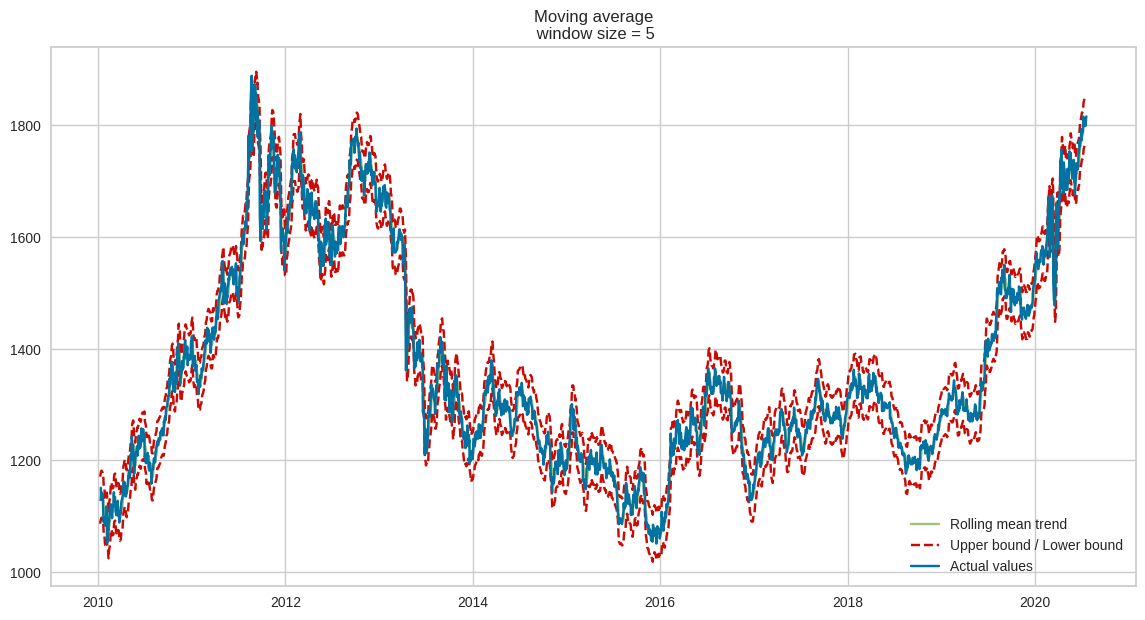

In [54]:
plot_moving_average(values.Gold, 5, plot_intervals=True)

MAE for window size:  15  is  21.633282427481465


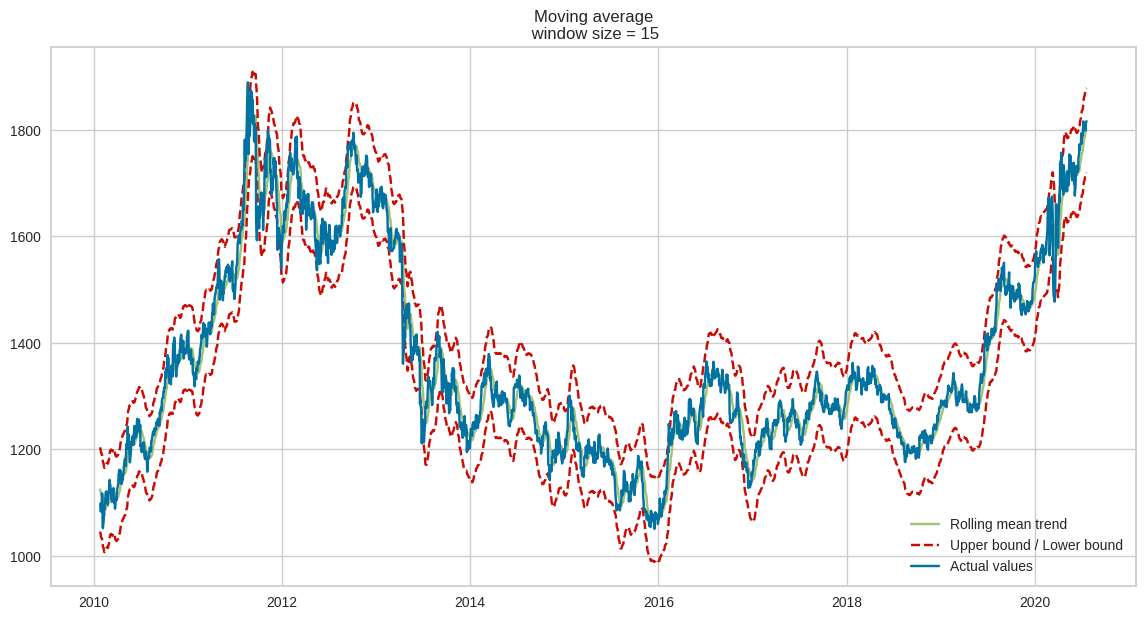

In [55]:
plot_moving_average(values.Gold, 15, plot_intervals=True)

MAE for window size:  30  is  31.302281567572212


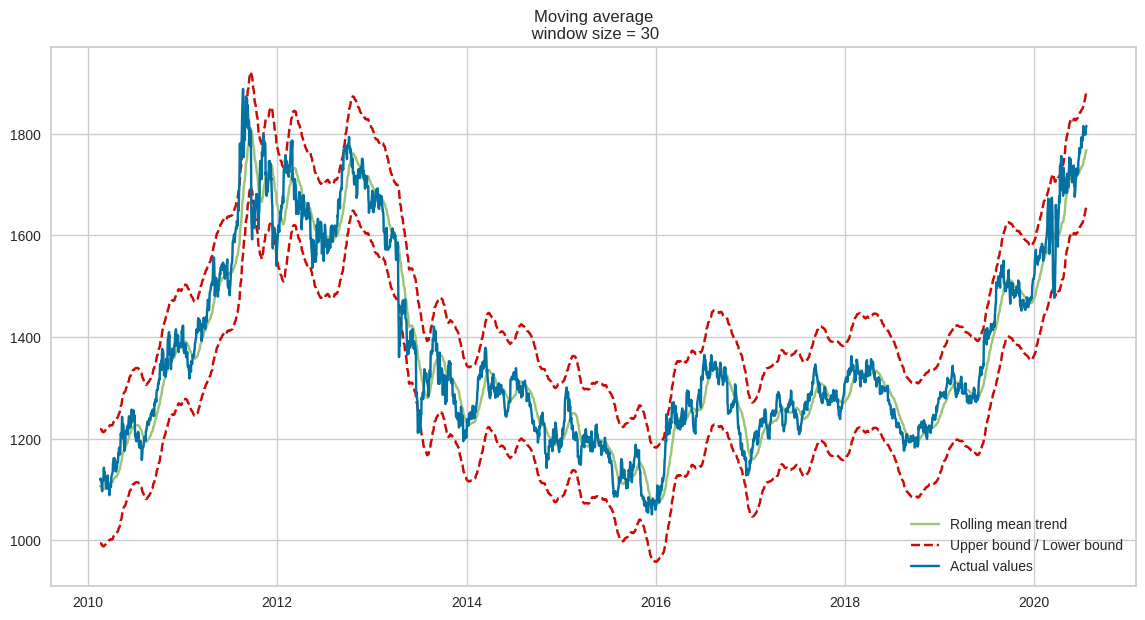

In [56]:
plot_moving_average(values.Gold, 30, plot_intervals=True)

The moving average plots show that smaller window size ( 5 here)
is performing better than other. We also could develop a function to find the best value of the window automatically.

we use a the moving average of the last 5 days of gold price to predict Gold price on 24th July.


To do this, we use **Recursive Multi-step Forecast**, which means the prediction for the prior time step is used as an input for making a prediction on the following time step.

In [57]:
#from datetime import datetime, timedelta
def MA_model(past_data, future_steps, window=5 ):

  # as forcasting for the future_steps, we need to predict each step in future_step
  past=past_data.copy()
  for t in range(future_steps):
    mean=pd.Series(past).rolling(window=window).mean()[-1:]
    past.append (mean)

  prediction = int(past[-1])
  return prediction


predictions, rmse, mae = walk_forward(MA_model, train['Gold'], test['Gold'], future_steps=4, trace=False)
pred=MA_model(values['Gold'], future_steps=4)

print ("The gold closing price on 24th July 2020 will be:", pred)
add_result(['Moving Average', mae, pred, 'Walk Forward Validation'])

walk-forward validation using <function MA_model at 0x7e12bfeca0e0>
RMSE: 33.377
MAE: 21.405
The gold closing price on 24th July 2020 will be: 1815


,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation
2,Moving Average,21.404743,1815,Walk Forward Validation


## Exponential Smoothing

let's see how exponential_smoothing is performing

In [58]:
def exponential_smoothing(series, alpha=0.3):
    model = SimpleExpSmoothing(np.asarray(series))
    fit = model.fit(smoothing_level=alpha)
    result =fit.fittedvalues

    return result


In [59]:
def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);


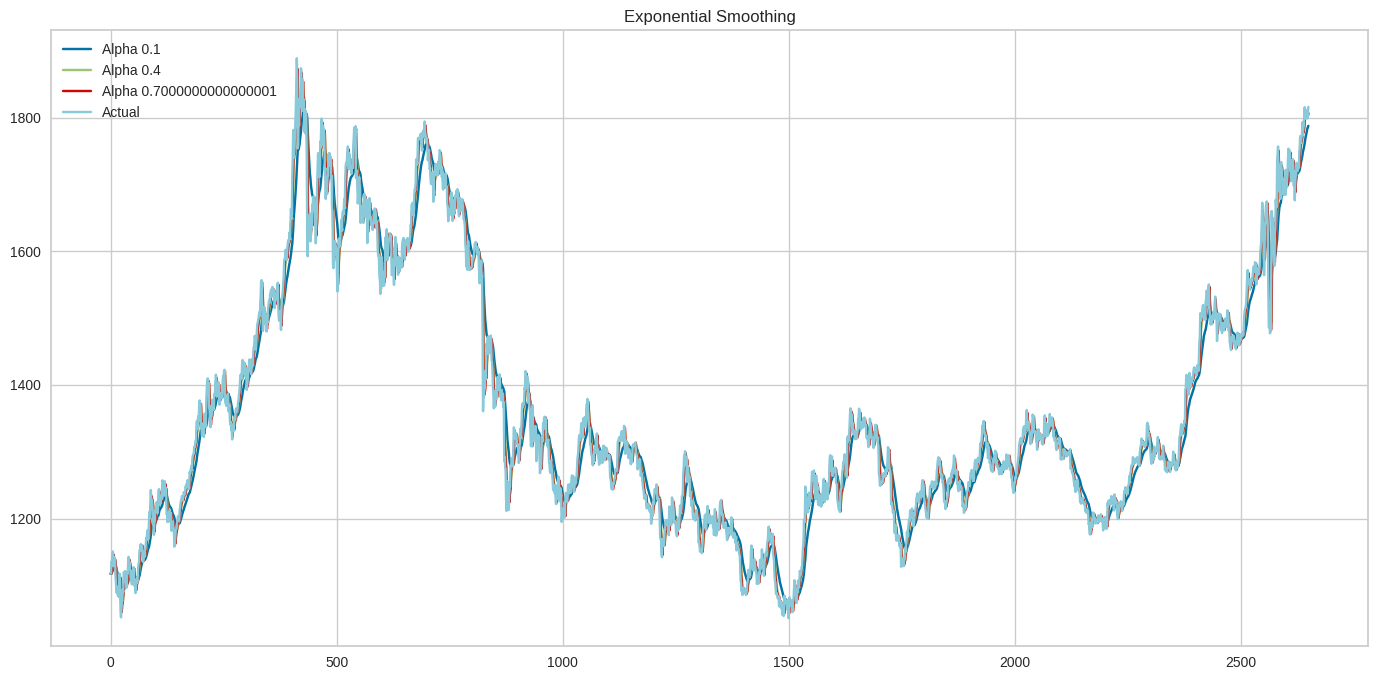

In [60]:
param_alpha= [a for a in np.arange(0.1, 0.9, 0.3)]
plot_exponential_smoothing(values.Gold,param_alpha )

let's see how exponential smoothing is performing using walkforwrad validation, when predicting the next four days.

In [62]:
 def ES_model(past_data, future_steps, alpha=0.9 ):

  # Recursive Multi-step Forecast
  #past=past_data.copy()
  past = [x for x in past_data]
  for t in range(future_steps):
      model = SimpleExpSmoothing(np.asarray(past))
      fit = model.fit(smoothing_level=alpha)
      forcast = fit.forecast(1)[-1:]
      past.append (float(forcast))

  prediction = int(past[-1])
  return prediction


predictions, rmse, mae = walk_forward(ES_model, train['Gold'], test['Gold'], future_steps=4, trace=False)
pred=ES_model(values['Gold'], future_steps=4)

print ("The gold closing price on 24th July 2020 will be:", pred)
add_result(['Exponential Smoothing', mae, pred, 'Walk Forward Validation'])

walk-forward validation using <function ES_model at 0x7e12bddae0e0>
RMSE: 33.103
MAE: 21.394
The gold closing price on 24th July 2020 will be: 1815


,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation
2,Moving Average,21.404743,1815,Walk Forward Validation
3,Exponential Smoothing,21.394118,1815,Walk Forward Validation


## Double Exponential Smoothing
Double Exponential Smoothing is similar to Single Exponential Smoothing Model. But, It has two smoothing parameters: one for level and the other one for trend.  It is also called Holt's Exponential Smoothing Model.
let's see how exponential_smoothing is performing when forcasting the next day price only

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exponential_holt_smoothing(series, alpha=0.9, beta=0.02):

    model = Holt(np.asarray(series))
    fit = model.fit(smoothing_level=alpha, smoothing_slope=beta)
    result =fit.fittedvalues

    return result

In [65]:
def plot_exponential_holt_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot( exponential_holt_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

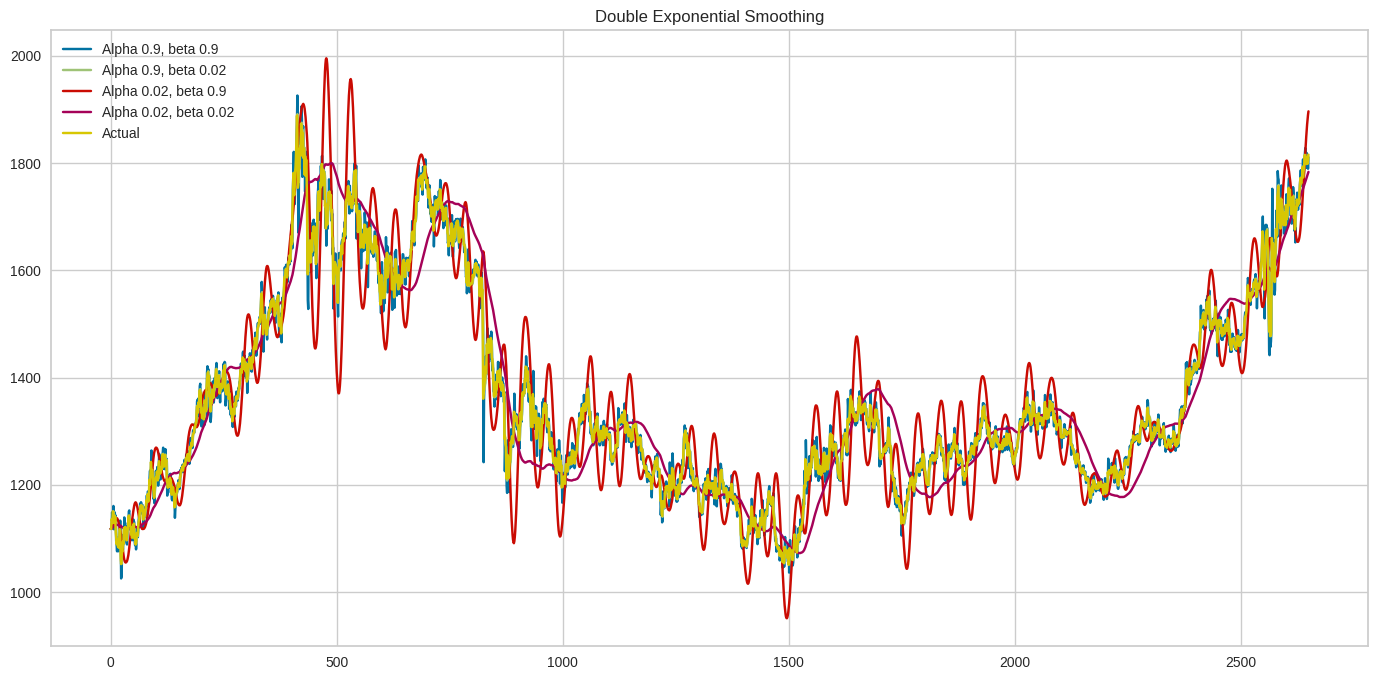

In [66]:
plot_exponential_holt_smoothing(values.Gold, alphas=[0.9, 0.02], betas=[0.9, 0.02])

let's see how exponential smoothing is performing using walkforwrad validation, when predicting the next four days.

In [69]:
def DES_model(past_data, future_steps, alpha=0.9, beta=0.02 ):

  # Recursive Multi-step Forecast
  past = [x for x in past_data]
  for t in range(future_steps):
      model = Holt(np.asarray(past))
      fit = model.fit(smoothing_level=alpha, smoothing_slope=beta)
      forcast = fit.forecast(1)[-1:]
      past.append (float(forcast))

  prediction = int(past[-1])
  return prediction


predictions, rmse, mae = walk_forward(DES_model, train['Gold'], test['Gold'], future_steps=4, trace=False)
pred=DES_model(values['Gold'], future_steps=4)

print ("The gold closing price on 24th July 2020 will be:", pred)
add_result(['Double Exponential Smoothing', mae, pred,'Walk Forward Validation'])

walk-forward validation using <function DES_model at 0x7e12bdac5630>
RMSE: 33.522
MAE: 21.087
The gold closing price on 24th July 2020 will be: 1824


,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation
2,Moving Average,21.404743,1815,Walk Forward Validation
3,Exponential Smoothing,21.394118,1815,Walk Forward Validation
4,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation
5,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation


##  Compare All

Let's compare the performance of EMA, Expanding Average, Moving Avergae, etc all together

In [70]:
display(summary)

,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation
2,Moving Average,21.404743,1815,Walk Forward Validation
3,Exponential Smoothing,21.394118,1815,Walk Forward Validation
4,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation
5,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation


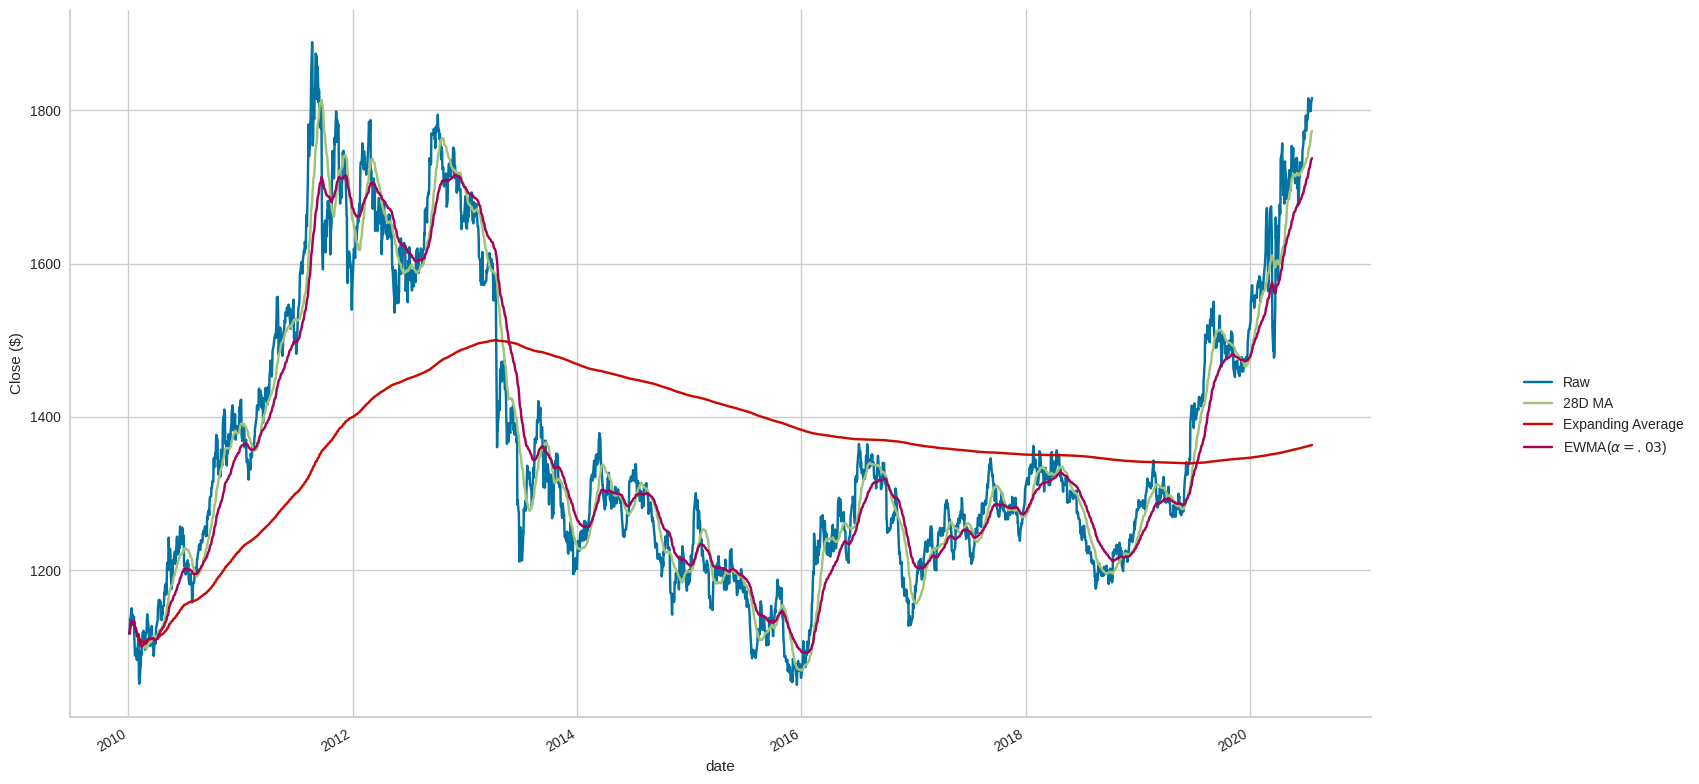

In [71]:
plt.figure(figsize=(17, 8))
values.Gold.plot(label='Raw')
values.Gold.rolling(28).mean().plot(label='28D MA')
values.Gold.expanding().mean().plot(label='Expanding Average')
values.Gold.ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

plt.legend(bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.ylabel("Close ($)")
sns.despine()

# Supervised Learning Prediction


Time series forecasting can be framed as a supervised learning problem. This re-framing of your time series data allows us to use powerful machine learning algorithms.

We can do this by using previous time steps as input variables and use the next time step as the output variable.

## Feature Engineering


In [72]:
values=make_initial_data()
values.tail()

,year,month,Gold
date,,,
2020-07-14,2020,7,1810.599976
2020-07-15,2020,7,1811.400024
2020-07-16,2020,7,1798.699951
2020-07-17,2020,7,1808.300049
2020-07-20,2020,7,1815.900024


### Feature Engineering Based on Financial Markets



#### Import more data from yahoo financials

Based on my limited search this week, I found some commodity and indexes that can be related to Gold price, which I import them here

In [73]:
ticker_names = ['Silver', 'Crude Oil', 'S&P500','MSCI EM ETF', 'Nasdaq',  '10 Yr US T-Note futures', '2 Yr US T-Note Futures', 'Volatility Index']
ticker_codes= [ 'SI=F', 'CL=F', '^GSPC', 'EEM', '^IXIC', 'ZN=F', 'ZT=F', '^VIX'	 ]

In [74]:
yahoo_financials = YahooFinancials('GC=F')
values=values.reset_index()
counter=0
for i in ticker_codes:

    #Extracting Data from Yahoo Finance, returns the output in a JSON format
    yahoo_financials = YahooFinancials(i)
    raw_data = yahoo_financials.get_historical_price_data(start_date, end_date, "daily")

    #Extracting the closing prices from the JSON file
    df = pd.DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    df.columns = ['Date-tmp',ticker_names[counter]]
    df['Date-tmp']= pd.to_datetime(df['Date-tmp'])

    #Adding the new instrument prices to the dataframe, Merging based on date as key
    values = values.merge(df,how='left',left_on='date',right_on='Date-tmp')
    values = values.drop(labels='Date-tmp',axis=1)
    counter +=1

In [75]:
values.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2651 entries, 0 to 2650
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     2651 non-null   datetime64[ns]
 1   year                     2651 non-null   int64         
 2   month                    2651 non-null   int64         
 3   Gold                     2651 non-null   float64       
 4   Silver                   2651 non-null   float64       
 5   Crude Oil                2651 non-null   float64       
 6   S&P500                   2651 non-null   float64       
 7   MSCI EM ETF              2651 non-null   float64       
 8   Nasdaq                   2651 non-null   float64       
 9   10 Yr US T-Note futures  2649 non-null   float64       
 10  2 Yr US T-Note Futures   2651 non-null   float64       
 11  Volatility Index         2651 non-null   float64       
dtypes: datetime64[ns](1), float64(9), 

#### Null Records
Yahoo financial produced some records will null values. Before feature engineering, which will be based on these records, we need to fix these records.

 We have different options to deal with the null records:
* Drop Columns with Missing Values
* Imputing the missing values, for example we can fill in the mean value along each column.
* Imputing the missing values, but  considering which values were originally missing.

In here, I choose to impute the missing values using backward fill ( copying the last available value). Additionally, for each column with missing entries in the original dataset, I add a new column that shows the location of the imputed entries

In [76]:
print(values.isnull().sum(axis = 0))
_=show_null_records(values, show=False)

date                       0
year                       0
month                      0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
MSCI EM ETF                0
Nasdaq                     0
10 Yr US T-Note futures    2
2 Yr US T-Note Futures     0
Volatility Index           0
dtype: int64

Number of Records with null values

2


In [77]:
cols_with_missing = [col for col in values.columns  if values[col].isnull().any()]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    values[col + '_was_missing'] = values[col].isnull().astype(int)

values = values.fillna(method="bfill",axis=0)
_=show_null_records(values, show=True)
values.info()


Number of Records with null values

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2651 entries, 0 to 2650
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2651 non-null   datetime64[ns]
 1   year                                 2651 non-null   int64         
 2   month                                2651 non-null   int64         
 3   Gold                                 2651 non-null   float64       
 4   Silver                               2651 non-null   float64       
 5   Crude Oil                            2651 non-null   float64       
 6   S&P500                               2651 non-null   float64       
 7   MSCI EM ETF                          2651 non-null   float64       
 8   Nasdaq                               2651 non-null   float64       
 9   10 Yr US T-Note futures              2651 non-

#### Short Term Historical Returns


Add percentage change of gold and the important commidities since the last few days

In [78]:
# Calculating Short Term  Historical Returns
imp_cols=['Gold']
for ticker in ticker_names:
  imp_cols.append(ticker)

change_days = [1,3,5,14,21]
cols= ticker_names

print("New shape of our dataset:")
for i in change_days:
    print(values.shape)
    x= values[imp_cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    values=pd.concat(objs=(values,x),axis=1)
    x=[]
print(values.shape)

New shape of our dataset:
(2651, 13)
(2651, 22)
(2651, 31)
(2651, 40)
(2651, 49)
(2651, 58)


#### Long Term Historical Returns

Add percentage change of gold and the important commidities since the previous months

In [79]:
# Calculating Long Term Historical Returns

imp_cols= ['Gold','Silver', 'Crude Oil', 'S&P500','MSCI EM ETF']
change_days = [60,90,180,250]

print("New shape of our dataset:")
for i in change_days:
    print(values.shape)
    x= values[imp_cols].pct_change(periods=i).add_suffix("-T-"+str(i))
    values=pd.concat(objs=(values,x),axis=1)
    x=[]
print(values.shape)

New shape of our dataset:
(2651, 58)
(2651, 63)
(2651, 68)
(2651, 73)
(2651, 78)


### Feature Engineering Based on Time Series Techniques

#### Date Time Features


In [80]:
values['quarter'] = values['date'].dt.quarter
values['dayofweek'] = values['date'].dt.dayofweek

#### Lag  Features
 these are values at prior time steps.

 Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted
values looks as follows:
Value(t), Value(t+1)
Value(t), Value(t+1)
Value(t), Value(t+1)

In [81]:
change_days = [1,3,5,14,21]

print("New shape of our dataset:")
for i in change_days:
    print(values.shape)
    title="Gold-"+str(i)
    values[title]= values.Gold.shift(periods = i)

print(values.shape)

New shape of our dataset:
(2651, 80)
(2651, 81)
(2651, 82)
(2651, 83)
(2651, 84)
(2651, 85)


#### Simple Moving Average (SMA)  
SMA assigns equal weighting to all previous values

In [82]:
# Calculate Simple Moving Average for
def cal_SMA(df, feature, window):
    return df[feature].rolling(window=window).mean()


moving_avg = pd.DataFrame(values['date'])
feature='Gold'

for window in [5, 15,30, 50, 100, 200]:
    title= str(feature)+'-'+ str(window)+'-SMA'
    moving_avg[title] = cal_SMA (values,feature,window)

#### Exponentially Moving Average (EMA)


 Since EMAs place a higher weighting on recent data than on older data, they are more reactive to the latest price changes than SMAs are, which makes the results from EMAs more timely and explains why the EMA is the preferred average among many traders.

In [83]:
# Calculate Exponential Moving Average
def cal_EMA(df, feature, window):
    return df[feature].ewm(span=window, adjust=True,ignore_na=True).mean()


In [84]:
for window in [90, 180]:
      title= str(feature)+'-'+ str(window)+'-EMA'
      moving_avg[title] = cal_EMA (values,feature,window )


print(moving_avg.shape)



(2651, 9)


In [85]:
#Merging Moving Average values to the feature space
values = pd.merge(left=values,right=moving_avg,how='left',on='date')

del moving_avg
gc.collect()

66922

In [86]:
print("New shape of our dataset:")
print(values.shape)
_=show_null_records(values, show=False)

New shape of our dataset:
(2651, 93)

Number of Records with null values

250


## Null Records

We are again ended up with null records, which are created during feature generation and due to large window sizes.  Since the null records are only in the begining of the data set, we can safely remove them.



In [87]:
 display(values.isnull().sum(axis=0))

,0
date,0
year,0
month,0
Gold,0
Silver,0
...,...
Gold-50-SMA,49
Gold-100-SMA,99
Gold-200-SMA,199
Gold-90-EMA,0


In [88]:
values=values.dropna(axis=0)
_=show_null_records(values, show=False)

print("New shape of our dataset:")
values.shape


Number of Records with null values

0
New shape of our dataset:


(2401, 93)

## Adding Target

As the purpose of this challenge is predicting the price of gold at market close on Friday July 24th and our submissions due will be on Tuesday July 21st, we use Gold closing price  after shifting it by -4.

In [89]:
shift_val=-4

#Caluculating forward returns for Target
y =  DataFrame(data=values['date'])

#Caluculating forward returns for Target with respect to the next 4 day
title= 'Gold-T+'+ str(abs(shift_val))
y[title]=values["Gold"].shift(shift_val, axis = 0)

Merging the target variables with the feature space

In [90]:
#Adding Target Variables
data = pd.merge(left=values,right=y,how='inner',on='date',suffixes=(False,False))
print("New shape of our dataset:")
print(data.shape)

del values
gc.collect()

New shape of our dataset:
(2401, 94)


0

Let's save the training data

In [91]:
save=False
if save:
 data.to_csv("Training_Data.csv",index=False)

## Explanatory Data Analysis

> Indented block

> Indented block

> Indented block








In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 0 to 2400
Data columns (total 94 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2401 non-null   datetime64[ns]
 1   year                                 2401 non-null   int64         
 2   month                                2401 non-null   int64         
 3   Gold                                 2401 non-null   float64       
 4   Silver                               2401 non-null   float64       
 5   Crude Oil                            2401 non-null   float64       
 6   S&P500                               2401 non-null   float64       
 7   MSCI EM ETF                          2401 non-null   float64       
 8   Nasdaq                               2401 non-null   float64       
 9   10 Yr US T-Note futures              2401 non-null   float64       
 10  2 Yr US T-No

In [93]:
data.describe()

,year,month,Gold,Silver,Crude Oil,S&P500,MSCI EM ETF,Nasdaq,10 Yr US T-Note futures,2 Yr US T-Note Futures,...,Gold-21,Gold-5-SMA,Gold-15-SMA,Gold-30-SMA,Gold-50-SMA,Gold-100-SMA,Gold-200-SMA,Gold-90-EMA,Gold-180-EMA,Gold-T+4
count,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,...,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2397.000000
mean,2015.281549,6.387755,1377.726114,20.961654,69.751924,2108.078262,33.811957,5241.134194,127.386161,108.918029,...,1374.254103,1377.385881,1376.516840,1375.311452,1373.796392,1369.947337,1362.533271,1370.777697,1365.043706,1377.677347
std,2.767947,3.413942,190.645948,7.195511,23.897191,581.652755,3.869820,1993.296294,4.675553,1.461082,...,186.696389,189.779583,187.870132,185.273016,182.232873,175.367339,164.696571,174.107082,160.883746,190.799902
min,2010.000000,1.000000,1050.800049,11.735000,-37.630001,1099.229980,23.567734,2335.830078,117.671875,105.156250,...,1050.800049,1060.339990,1068.193335,1069.853341,1076.764004,1106.757999,1131.678500,1100.215327,1124.950073,1050.800049
25%,2013.000000,3.000000,1238.500000,16.136000,49.830002,1615.410034,31.194078,3409.169922,124.546875,108.070312,...,1238.500000,1239.480005,1238.933325,1240.303333,1244.684009,1245.599996,1251.374503,1241.229819,1245.434674,1238.400024
50%,2015.000000,6.000000,1311.000000,17.584999,62.759998,2072.780029,33.512756,4903.089844,126.953125,109.531250,...,1311.000000,1310.759985,1308.506665,1307.386682,1305.254001,1300.727002,1289.606501,1299.173713,1304.627729,1310.800049
75%,2018.000000,9.000000,1526.599976,23.316999,93.980003,2639.399902,36.455753,7006.899902,130.734375,110.132812,...,1514.900024,1527.019995,1519.606673,1516.966667,1509.054001,1499.734996,1488.682997,1496.156643,1476.040757,1526.599976
max,2020.000000,12.000000,1888.699951,48.584000,113.930000,3386.149902,45.169636,10767.089844,139.500000,110.421875,...,1888.699951,1853.719995,1829.473332,1809.990002,1749.420005,1726.276002,1697.369003,1714.007195,1683.653541,1888.699951



Let's find the correlation between features and our target in the last 200 records.

,Gold-T+4
Gold-200-SMA,0.937856
Gold-180-EMA,0.933718
Gold-90-EMA,0.927907
Gold,0.927014
Gold-5-SMA,0.920456
...,...
Crude Oil-T-90,-0.587713
Crude Oil-T-250,-0.595582
Crude Oil-T-180,-0.620286
Crude Oil,-0.653608


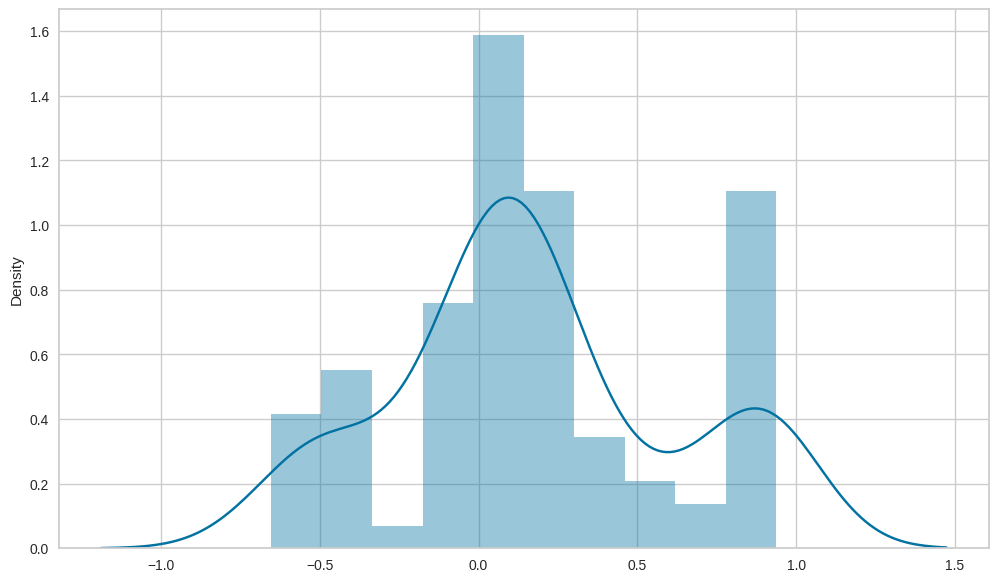

In [94]:
plt.figure(figsize=(12,7))
corr_data = data.tail(200).corr().iloc[:,-1:].drop(labels=['Gold-T+4'],axis=0)
corr_data = corr_data.sort_values('Gold-T+4',ascending=False)
corr_data = pd.DataFrame(corr_data['Gold-T+4'])

sns.distplot(corr_data)
display(corr_data)

It seems there are some high correlated features, which we can leverage in our modelling

## Validation Strategy

 In order to reduce the training time, we use time series cross validation, instead of walk forward validation which designed in our time series prediction.
The demonstration of our cross validation is shown below.

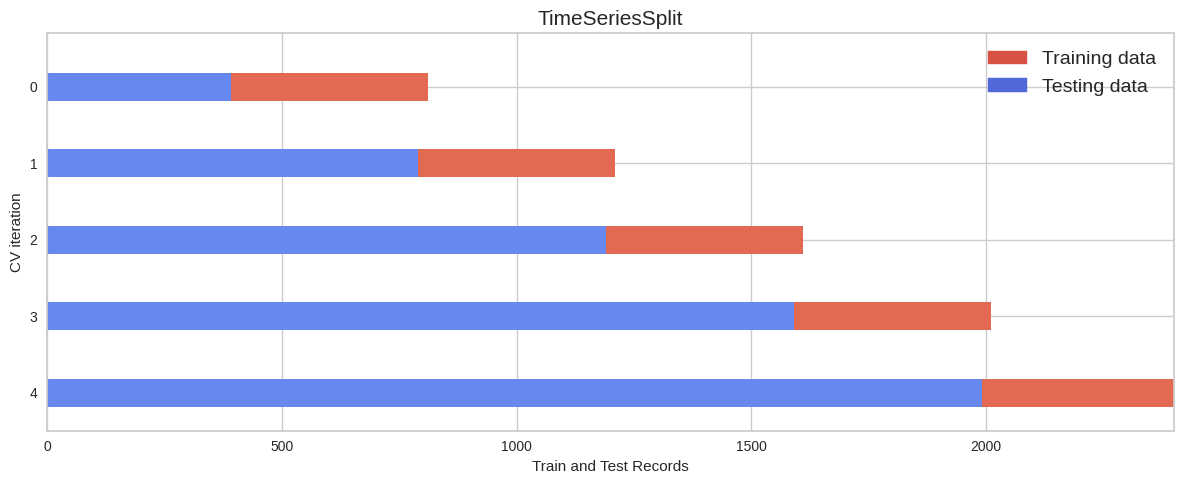

In [95]:
data=data.set_index('date')

X= data.drop('Gold-T+4', axis=1)
y= data['Gold-T+4']
n_splits =5
cv = TimeSeriesSplit(n_splits=n_splits)


cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots(figsize=(12, 5),)
plot_cv_indices(cv, X, y,  ax, n_splits, lw=20)
ax.legend([Patch(color=cmap_cv(.9)), Patch(color=cmap_cv(.07))], [ 'Training data', 'Testing data'], prop={'size': 14})
plt.tight_layout()
plt.show()

## Data Preprocessing

In [96]:
print(" shape of our dataset:")
print(data.shape)
_=show_null_records(data, show=False)

 shape of our dataset:
(2401, 93)

Number of Records with null values

4


In [97]:

columns=data.columns.drop('Gold-T+4')

# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in columns if
                    data[cname].dtype == "object"]


# Select numerical columns
numerical_cols = [cname for cname in columns if
                  data[cname].dtype in ['int64', 'float64']]


X= data.drop('Gold-T+4', axis=1)
y= data['Gold-T+4']

# Preprocessing for numerical data
numerical_transformer = MinMaxScaler()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# all records except the last four rows
X_train=X[:-4]
y_train=y[:-4]

# The true outcome of Gold price for the next four days are missing, so we keep these records as final test
X_test= X[-4:]
y_test= y[-4:]



##  Modelling

In [98]:
def inspect(grid, x_test, model):
  print("Best Hyperparameters::\n{}".format(grid.best_params_))
  print('Best MAE score:', grid.best_score_)
  mae= -1*grid.best_score_
  preds_test = grid.predict(x_test)
  print("The gold closing price on 24th July 2020 will be: ", preds_test[-1])
  add_result([model,mae  , preds_test[-1], 'Time Series Cross Validation'])

In [99]:
model = LinearRegression()

param_grid = {}
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model),
                           ])

grid_LR = GridSearchCV(pipeline,
                       param_grid,
                       cv=cv,
                       verbose=0,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error'
                       )

grid_LR.fit(X_train, y_train)

inspect(grid_LR, X_test,'Linear Regression')


Best Hyperparameters::
{}
Best MAE score: -87.64804895165231
The gold closing price on 24th July 2020 will be:  1840.7113605051643


### Random Forest Regressor

In [100]:
model = RandomForestRegressor(random_state=42)

param_grid = {"model__n_estimators": [3, 10, 30, 50],
              "model__max_features": [2, 4, 6, 8],
              "model__n_estimators": [3, 10],
              "model__max_features": [2, 3, 4],

              }

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)
                           ])

grid_RF = GridSearchCV(pipeline,
                       param_grid,
                       cv=cv,
                       verbose=0,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error'
                       )

grid_RF.fit(X_train, y_train)

inspect(grid_RF, X_test, 'Random Forest Regressor')


Best Hyperparameters::
{'model__max_features': 3, 'model__n_estimators': 10}
Best MAE score: -61.165389401237476
The gold closing price on 24th July 2020 will be:  1756.1199951171875


### Decision Tree Regressor

In [101]:
model = DecisionTreeRegressor(max_depth=4,
                              min_samples_split=5,
                              max_leaf_nodes=10)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)
                           ])

param_grid = {
    "model__min_samples_split": [10, 20, 40],
    "model__max_depth": [2, 6, 8],
    "model__min_samples_leaf": [20, 40, 100],
    "model__max_leaf_nodes": [5, 20, 100],
}

grid_DT = GridSearchCV(pipeline,
                       param_grid,
                       cv=cv,
                       verbose=0,
                       n_jobs=-1,
                       scoring='neg_mean_absolute_error'
                       )

grid_DT.fit(X_train, y_train)

inspect(grid_DT, X_test, 'Decision Tree Regressor')

Best Hyperparameters::
{'model__max_depth': 6, 'model__max_leaf_nodes': 20, 'model__min_samples_leaf': 40, 'model__min_samples_split': 20}
Best MAE score: -61.02524871577286
The gold closing price on 24th July 2020 will be:  1781.7013483820735


### Blending

Blending models is a method of ensembling which uses consensus among estimators to generate final predictions. In here,  we combine different machine learning algorithms and use majority vote to make the final prediction

In [102]:
blend = VotingRegressor([('DT', grid_DT), ('RF', grid_RF), ('LR', grid_LR)])
_=blend.fit(X_train, y_train)

preds_test = blend.predict(X_test)
print("The gold closing price on 24th July 2020 will be: ", preds_test[-1])
#add_result(['Blend', 'NA' , preds_test[-1], 'Time Series Cross Validation'])

The gold closing price on 24th July 2020 will be:  1792.844234668142


### Making predictions
Now we use our ensemble to make the final prediction.

In [103]:
pred1 = grid_DT.predict(X_test)
pred2 = grid_RF.predict(X_test)
pred3 = grid_LR.predict(X_test)
pred4 = blend.predict(X_test)
final_prediction=pred4

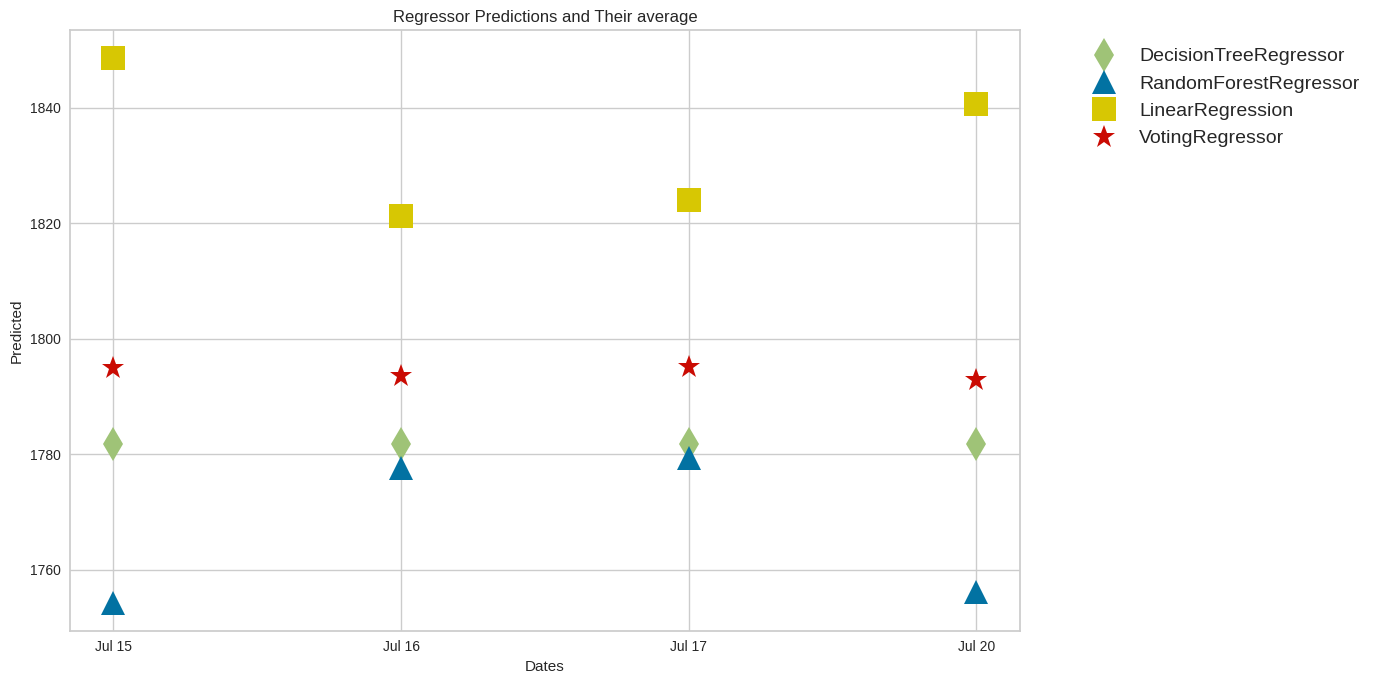

In [104]:
markersize=17

labels=[]
for elem in X_test.index[-4:]:
  labels.append(elem.strftime("%b %d"))


plt.figure(figsize=(14,7))
plt.plot(pred1, 'gd', label='DecisionTreeRegressor', markersize=markersize)
plt.plot(pred2, 'b^', label='RandomForestRegressor', markersize=markersize)
plt.plot(pred3, 'ys', label='LinearRegression', markersize=markersize)
plt.plot(pred4, 'r*', label='VotingRegressor', markersize=markersize)


#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Predicted')
plt.xlabel('Dates')
plt.legend(prop={'size': 14}, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Regressor Predictions and Their average')
plt.xticks(np.arange(len(labels)), labels)
plt.tight_layout()
plt.show()

In [105]:
summary

,Model,MAE,Prediction,validation
0,Persistence,21.314043,1815.900024,Walk Forward Validation
1,Arima,21.362138,2651 1815.761380 2652 1815.800030 2653 ...,Walk Forward Validation
2,Moving Average,21.404743,1815,Walk Forward Validation
3,Exponential Smoothing,21.394118,1815,Walk Forward Validation
4,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation
5,Double Exponential Smoothing,21.086719,1824,Walk Forward Validation
6,Linear Regression,87.648049,1840.711361,Time Series Cross Validation
7,Random Forest Regressor,61.165389,1756.119995,Time Series Cross Validation
8,Decision Tree Regressor,61.025249,1781.701348,Time Series Cross Validation


## PyCaret

In order to get idea of how better other models can perform, let's try Pycaret Package and try different bunch of models

In [106]:
from pycaret.regression import *
a=setup(data,target='Gold-T+4',
        session_id=11,
        silent=True,profile=True,remove_outliers=False,
        normalize=True, normalize_method="minmax")

TypeError: setup() got an unexpected keyword argument 'silent'

### Compare Various model performance Using Caret



In [ ]:
compare_models(blacklist=['tr','ard'],turbo=True)

In [ ]:
et = create_model('et')
et_tuned = tune_model('et')
evaluate_model(et)

In [ ]:
# plotting a model
plot_model(et)

In [ ]:
interpret_model(et)

In [ ]:
interpret_model(et, plot = 'correlation')

In [ ]:
interpret_model(et, plot = 'reason', observation = 10)

In [ ]:
knn_tuned = tune_model('knn',n_iter=15)
knn_tuned_bagged = ensemble_model(knn_tuned, method='Bagging')

In [ ]:
catb = create_model('catboost')

In [ ]:
et_bagged = ensemble_model(et,method='Bagging')

In [ ]:
blend_knn_et = blend_models(estimator_list=[knn_tuned,et])

In [ ]:
stack1 = create_stacknet(estimator_list=[[catb,knn_tuned],[et,blend_knn_et]],restack=True)

# My Prediction
The closing price of gold on July 24th will be 1793 $

In [ ]:
final_prediction[-1]

# Conclusion

In this work, we have trained various time series and supervised learning models to predict the closing price of Gold.  Some of these models  are easy to understand and interpret. These models can be suggested to users with the requirement understanding  the model decision process.
We have also tried more complex models for users who prioritize performance over  understanding the process of model prediction happens behind the scene. Based on the user preference, we can decide the model to be deployed.




# Caveat

Forecasting the price of gold is a very complex problem, since various non quantitative factors such as international political situation can affect it dramatically. Hence, the models used here are not capable of fully understand the market and should not be used for investing guidance.

# Future Works

As a future direction, I am highly interested to
* Use NLP techniques to utilize the news, social media, political websites to generate more features  

* Use classification methods to predict the downward or upward trend of price